<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day1/3_multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer Perceptron on CIFAR10

Based on the previous exercise, we will train a multi-layer network, also known as multi-layer perceptron. This architecture introduces 'hidden layers', i.e. layers that receive input not from the images directly but from previous layers in the network and that are not directly observed in the output.

## Preperation

In [1]:
# load tensorboard extension
%load_ext tensorboard

In [24]:
# import torch and other libraries
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

In [ ]:
!pip install cifar2png

In [3]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is not available, training will run on the CPU


In [ ]:
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py 

In [4]:
# we will reuse the training function, validation function and
# data preparation from the previous notebook
import utils

In [5]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

output dir `cifar10` already exists. Please specify a different output path


In [6]:
categories = os.listdir('./cifar10/train')
categories.sort()

## Multi-layer perceptron

In this execise, we go from a single layer network to a network with multiple layers, also known as multi-layer perceptron, or MLP.
We still use fully connected layers (`nn.Linear`), i.e. each neuron in a given layer receives input from all neurons in the previous layer.

Imporantly, we apply a non-linearity to all layer outputs.
Otherwise, the layers could be collapsed into a single layer by matrix multiplication.

In [7]:
class MLP(nn.Module):
    def __init__(self, n_pixels, n_classes):
        super().__init__()
        self.n_pixels = n_pixels
        self.n_classes = n_classes
        
        # here, we define the structure of the MLP.
        # it's imporant that we use a non-linearity after each 
        # fully connected layer! Here we use the rectified linear
        # unit, short ReLu
        self.layers = nn.Sequential(
            nn.Linear(n_pixels, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.view(-1, self.n_pixels)
        x = self.layers(x)
        return x

In [11]:
# get training and validation data and loaders as well as the loss function
train_dataset, val_dataset = utils.make_cifar_datasets(cifar_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25)

loss_function = nn.NLLLoss()
loss_function.to(device)

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


NLLLoss()

In [12]:
# open the tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 12141), started 0:34:34 ago. (Use '!kill 12141' to kill it.)

In [31]:
# instantiate the model
# the first argument is the number of inputs
# = number of pixels = 3 * 32 * 32 = 3072
# the second argument is the number of output classes
model = MLP(3072, 10)
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=10, bias=True)
    (9): LogSoftmax(dim=1)
  )
)

In [32]:
# instantiate the optimizer and tensorboard
lr = 5.e-4

# in this exercise we will use a different optimizer:
# Adam (https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)
# Adam is a variant of stochastic gradient descent, that we will cover in more detail
# in the lecture tomorrow. We use it here because it makes training more stable 
# than the normal stochastic gradient descent
optimizer = Adam(model.parameters(), lr=lr)
tb_logger = SummaryWriter('runs/log_mlp1')

In [33]:
# train for a couple of epochs
n_epochs = 4
for epoch in trange(n_epochs):
    utils.train(model, train_loader, loss_function, optimizer,
                device, epoch, tb_logger=tb_logger)
    step = (epoch + 1) * len(train_loader)
    utils.validate(model, val_loader, loss_function,
                   device, step,
                   tb_logger=tb_logger)

100%|██████████| 4/4 [06:33<00:00, 98.40s/it]


In [18]:
# evaluate the model on test data
test_dataset = utils.make_cifar_test_dataset(cifar_dir)
test_loader = DataLoader(test_dataset, batch_size=25)

100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Test accuracy:
0.1


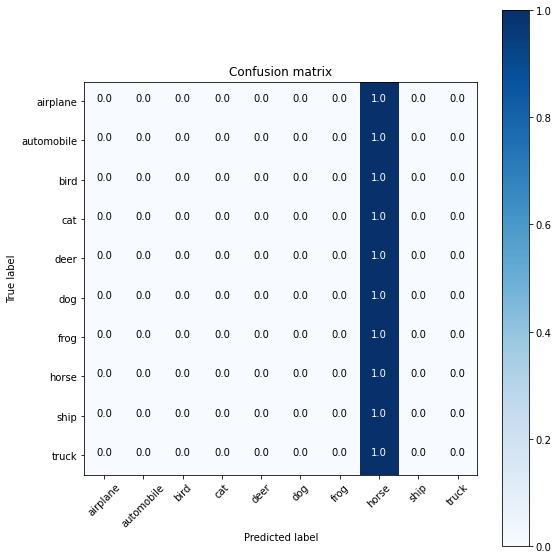

In [34]:
predictions, labels = utils.validate(model, test_loader, loss_function,
                                     device, step=0, tb_logger=None)

import matplotlib.pyplot as plt
print("Test accuracy:")
accuracy = metrics.accuracy_score(labels, predictions)
print(accuracy)

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(labels, predictions, categories, ax)

## Tasks and Questions

Tasks
- Try 2 or 3 different learning rate values and observe how this changes the training curves and performance on the test data.
- Implement a different MLP architecture. For example, you can increase the number of layers or use a different activation function (e.g. Sigmoid). Compare it to the previous architecture on the test dataset.

Question:
- Which learning rate is best for the initial MLP model?
- Can you find any systematic similarities or differences in the confusion matrix for the different models?
- How can you make the comparison of results more reliable?
